In [1]:
import numpy as np
import pandas as pd
import os, sys, pickle

from primate_reach_class import *
from utils import *
import matplotlib.pyplot as plt

The data used in this notebook is publicly available here: https://zenodo.org/record/583331#.Xicy1N-YUU   
Please read the description carefully. The 'indy_sessions.pkl' file contains 34 session recordings from one of the two monkeys. 
You can download it here: https://drive.google.com/file/d/1Tw61OU2J7ZdfJGvdQxCm0jeRV5crlUYd/view?usp=sharing

The video below shows a screencast for one of the sessions. You can see the switching target and the cursor controlled by indy.

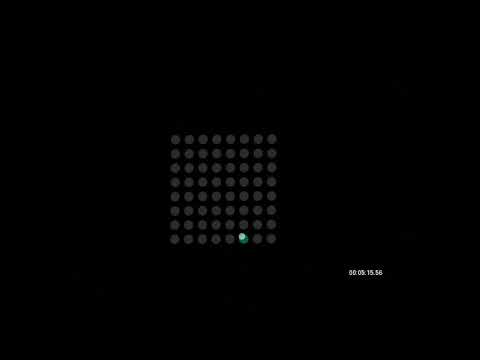

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('bPkpdpm03z8', width=800, height=300)

In [4]:
with open('indy_sessions.pkl', 'rb') as f:
    all_sessions = pickle.load(f)
print(len(all_sessions))

34


The raw data comes in the form of spike timings extracted from the extracellular recordings. 
I wrote a database class that allows to bin the data and remove cells with very low firing rates.

In [14]:
sessions = [5] # Chose the session you want to look at
fps = 20  # Chose the number of bins per second

PR = Primate_Reach(all_sessions, sessions, fps=fps)
PR.filt_units(min_sessions=1) # Remove all channels that are not active (have a firing rate below 0.5 Hz) 

For this session we have recordings for 383 cells, of which 238 are in M1 and 145 in S1. However most sessions only have cells from M1.
The sessions also vary a lot in their length (roughly between 7000 and 70000 timebins at 20 fps)

In [37]:
print('Active units (cells): ', PR.n_traces["xa_j"])
print('M1 cells: ', PR.n_traces["xa_m"])
print('S1 cells: ', PR.n_traces["xa_s"])
print('Number timbins: ', PR.T[0])

Active units (cells):  383
M1 cells:  238
S1 cells:  145
Number timbins:  31064


Load the binned spikes (383 cells x 31064 time bins), the target position, and the cursor position (i.e. the x,y coordinates of where the monkey points with his finger)

In [16]:
spikes = PR.spike_bs[0]
target = PR.target_pos[0]
cursor = PR.cursor_pos[0]
print(spikes.shape, target.shape)

(383, 31064) (2, 31064)


Plot of the target and cursor for the first 1000 timebins, you can see how the cursor follows the target with some time lag. 

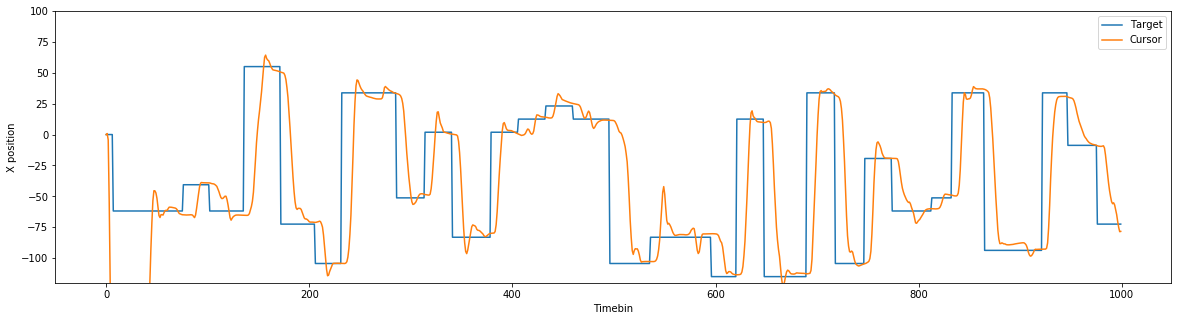

In [35]:
plt.figure(figsize=(20,5))
plt.plot(target[0][:1000], label='Target')
plt.plot(cursor[0][:1000], label='Cursor')
plt.ylim(-120,100)
plt.ylabel('X position')
plt.xlabel('Timebin')
plt.legend()

Lets say we want to find cells that respond to a movement of the target to the right. 
Here we just look at the correlation of the firing rate (with a certain time lag) of each cell with such a movement (np.diff gives us the the change from one bin to the next, np.clip removes movements to the left and makes the stimulus binary)

In [18]:
lag = 9
corrs_x = [np.corrcoef(spikes[i,1+lag:],np.clip(np.diff(target[0]),0,1)[:len(target[0])-lag-1])[0,1] for i in range(len(spikes))]

We find a couple of cells with correlations > 0.1. All cells left to the red line are from M1, and right of it from S1

Highest correlation:  287 0.16


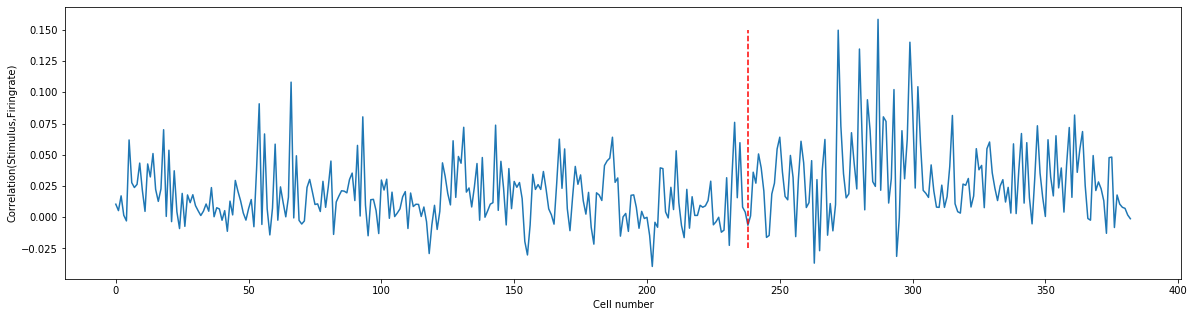

In [19]:
plt.figure(figsize=(20,5))
plt.plot(corrs_x)
plt.ylabel('Correlation(Stimulus,Firingrate)')
plt.xlabel('Cell number')
plt.plot([PR.n_traces["xa_m"],PR.n_traces["xa_m"]],[-0.025,0.15], linestyle='--', color='red')

print('Highest correlation: ', np.argmax(np.abs(corrs_x)), str(np.max(np.abs(corrs_x)).round(2)))

Select the cell with the highest correlation and plot it's firing rate and the stimulus (i.e. target movements to the right)

In [20]:
cell = spikes[287,1:]
stim_x = np.clip(np.diff(target[0]),0,np.inf)

Text(0.5, 0, 'Timebin')

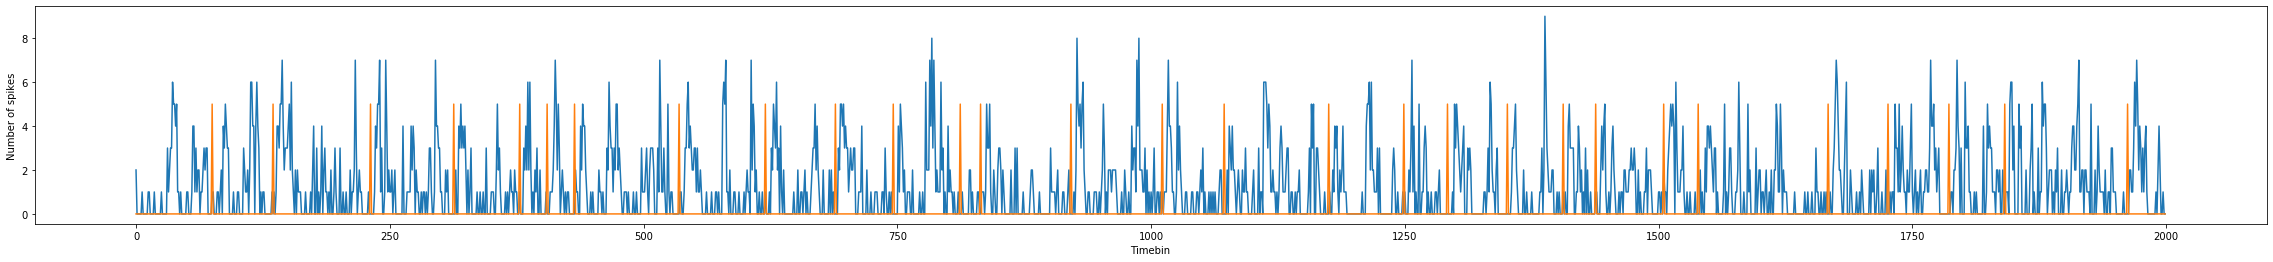

In [21]:
plt.figure(figsize=(40,4))
plt.plot(cell[:2000])
plt.plot(5*np.clip(stim_x,0,1)[:2000])
plt.ylabel('Number of spikes')
plt.xlabel('Timebin')

Collect the firing rate for 50 bins following each stimulus onset and create the stimulus in the format we used in the previous tutorial

In [22]:
stim_lags = 50
stims = np.zeros([len(stim_x[:-stim_lags].nonzero()[0]), stim_lags])
y = np.zeros_like(stims)

for i,n in enumerate(stim_x.nonzero()[0]):
    stims[i,0] = 1
    y[i] = cell[n:n+stim_lags]

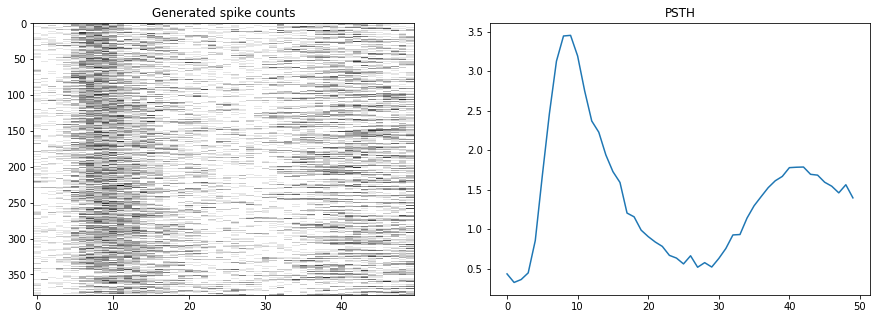

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Generated spike counts")
ax1.imshow(y, cmap='binary', aspect='auto')

PSTH = (y/stims[:,0][:,None]).mean(0)

ax2.set_title("PSTH")
ax2.plot(PSTH)

We can now calculate estimate of our filter and baseline and check how well our GLM explains the data

In [24]:
baseline = np.log(y.mean(0)[0])
_filter_est = np.log(PSTH) - baseline

In [25]:
from scipy.special import factorial

def get_mean_poisson_logl(s, r):
    return np.mean(s*np.log(r) -r - np.log(factorial(s)))

Plot the rate and calculate the Poisson LogL/timestep for that part

Text(0.5, 1.0, 'Poisson LogL.-1.77')

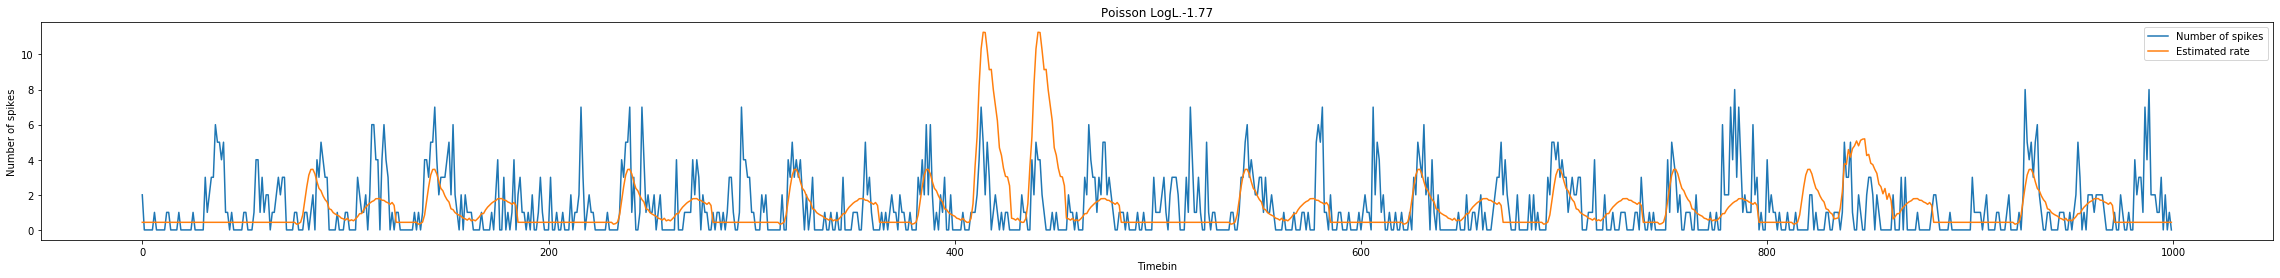

In [28]:
rate = np.exp(convolution(_filter_est, np.clip(stim_x,0,1)[:1000]) + baseline)
poisson_logl = get_mean_poisson_logl(cell[:1000], rate)

plt.figure(figsize=(40,4))
plt.plot(cell[:1000], label='Number of spikes')
plt.plot(rate, label='Estimated rate')
plt.legend()

plt.ylabel('Number of spikes')
plt.xlabel('Timebin')
plt.title('Poisson LogL.' + str(poisson_logl.round(2)))

We now encourage you to explore the dataset on your own.

    a) Try out other sessions, stimuli and lags. 
       Wrap the procedure outlined above into functions so you can quickly iterate over different possibilities.
       Can you find an even more stimulus driven cell? 
    b) Do you see a difference in correlation levels for the neurons recorded from motor cortex and somatosensory cortex?  
    c) The goal is to find the best GLM for your cell(s) in terms of the Poisson LogL. Review the following hypotheses:
        - Does the amplitude of the stimulus matter? I.e. do you get a better fit if you take it into account?
        - Do you find that these cells are similarly driven by x and y movements, or are they specialized on one direction? 
        - Similarly, do the cells respond to opposite movements (i.e. left/right, top,bottom)
        - You can also try to extract the filter using the STA and the finger position as stimulus.
    d) There could also be cells that encode the absolute position of the target and not the movement. Can you find one?

The notebooks GLM 2 (Part 1 and Part 2) contain advanced procedures for GLM fitting. 

    e) Perform an MLE estimate of the filter and baseline for your favourite Cell / Stimulus pair. 
    f) Perform a MAP estimate (optional).
    g) Construct a model using coupled neurons. Do these techniques improve your model fit (optional)?